Run this on a folder of pcmri where each GRE file has a corresponding _mask.nii.gz file. These can be in seperate folders (mask in path2derivatives, niftis in path2data) if you wish to keep derivatives and data separate.

For use with SCD data:
1) draw the masks save in data/
    example file name, since it matters for the script:
    sub-scd010_ses-01_run-1_rec-gre_mask_ves-all.nii.gz
2) copy masks to derivatives/flow/sub/ses/
3) Select the "SCD" MODIFY THIS CELL cell below
4) You can inspect the data using the final cell



In [1]:
import os
import re 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from nilearn import datasets, plotting, masking
from nilearn.input_data import NiftiSpheresMasker
from nilearn.image import concat_imgs, mean_img, smooth_img, math_img, load_img
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show
import nilearn.regions
import nibabel as nib
import scipy
import json

# Importing the flow anlysis tool such that it is a standard method of calculating flow
sys.path.append('/home/jeff/jeff.stout/repos/python')
import flow_analysis

In [2]:
# # For IVH data
# # set up names MODIFY THIS CELL WHEN YOU RUN THIS
# parent_path = '/home/jeff/jeff.stout/research/IVH'
# subject_str = 'B052'
# ses_str = 'ses-01'

# path2data = os.path.join(parent_path, 'NIFTI', subject_str, ses_str, 'flow')
# path2derivatives = os.path.join(parent_path, 'derivatives/flow', subject_str, ses_str)
# outdir = os.path.join(parent_path, 'derivatives/flow')
# fnamebase= subject_str + '_' +  ses_str + '_'

In [3]:
# for SCD
# set up names MODIFY THIS CELL WHEN YOU RUN THIS
parent_path = '/home/jeff/jeff.stout/research/SCD'
subject_str = 'sub-scd010'
ses_str = 'ses-01'

path2data = os.path.join(parent_path, 'data', subject_str, ses_str, 'flow')
path2derivatives = os.path.join(parent_path, 'derivatives/flow', subject_str, ses_str)
outdir = os.path.join(parent_path, 'derivatives/flow')
fnamebase= subject_str + '_' +  ses_str + '_'

print('path2data', '->       ', path2data)
print('path2derivatives', '->', path2derivatives)
print('outdir', '->          ', outdir)
print('fnamebase', '->', fnamebase)

path2data ->        /home/jeff/jeff.stout/research/SCD/data/sub-scd010/ses-01/flow
path2derivatives -> /home/jeff/jeff.stout/research/SCD/derivatives/flow/sub-scd010/ses-01
outdir ->           /home/jeff/jeff.stout/research/SCD/derivatives/flow
fnamebase -> sub-scd010_ses-01_


In [4]:
# this will generate the phase image path from the mask fname
# iff the data file name for the mask file is string preceeding "_mask"
def getphaseimg_path(mask_fname, path2data):
    base_filename = mask_fname[:mask_fname.find('mask')-1]
#     print('1 ', base_filename)
    base_filename = base_filename.replace("gre", "ph")
#     print('2 ', base_filename)
    return os.path.join(path2data, base_filename + '.nii.gz')

In [5]:
# Get list of *mask*.nii.gz files in the derivatives folder
# this determines which images to analyze
file_list = os.listdir(path2derivatives)
file_list_nii = [x for x in file_list if re.search('.nii.gz', x)]
file_list_nii.sort() # this makes certain that the "second series" is meaningful
# eliminate all entries with "all" in the file name
# file_list_nii = [s for s in file_list_nii if 'all' not in s]
# eliminate all entries with "csv" in the file name
file_list_nii = [s for s in file_list_nii if 'csv' not in s]
flows = pd.DataFrame(file_list_nii, columns=['mask_nii'])
flows['subject'] = fnamebase[:-1]

In [6]:
assert file_list_nii, 'You don''t have any masks defined.'

In [7]:
# get vencs
def getvenc(mask_fname, path2data):
#     print('mask_fname=', mask_fname, 'path2data=', path2data)
    path = getphaseimg_path(mask_fname, path2data)
    path = path.replace(".nii.gz", ".json")
    f = open(path, "r")
#     print('path=', path)
    data = json.loads(f.read())
    venc = data['VENC']
    f.close()
    return venc

# get vessel id from the mask file name
def getves(mask_fname):
    return mask_fname[mask_fname.find('mask')+5 : mask_fname.find('.nii')]

flows['vessel'] = flows.apply(lambda row: getves(row['mask_nii']), axis=1)
flows['VENC'] = flows.apply(lambda row: getvenc(row['mask_nii'], path2data), axis=1)

In [8]:
# Flows are calculated here using the function in /home/jeff/jeff.stout/repos/python/flow_analysis
flows["output"] = flows.apply(lambda row: flow_analysis.calc_flow(os.path.join(path2derivatives, row["mask_nii"]), getphaseimg_path(row["mask_nii"], path2data), row["VENC"]), axis=1)
flows = pd.concat([flows.drop(['output'], axis=1), flows['output'].apply(pd.Series)], axis=1) # unwinds the dictionary output in flows['output'] into seperte series


mask_path: /home/jeff/jeff.stout/research/SCD/derivatives/flow/sub-scd010/ses-01/sub-scd010_ses-01_run-1_rec-gre_mask_ves-all.nii.gz
vox_area = 0.006233
multiple cardiac phases (10, to be precise) are present!
area of mask = 0.367729, mask vox count = 59

mask_path: /home/jeff/jeff.stout/research/SCD/derivatives/flow/sub-scd010/ses-01/sub-scd010_ses-01_run-1_rec-gre_mask_ves-ba.nii.gz
vox_area = 0.006233
multiple cardiac phases (10, to be precise) are present!
area of mask = 0.074792, mask vox count = 12

mask_path: /home/jeff/jeff.stout/research/SCD/derivatives/flow/sub-scd010/ses-01/sub-scd010_ses-01_run-1_rec-gre_mask_ves-lica.nii.gz
vox_area = 0.006233
multiple cardiac phases (10, to be precise) are present!
area of mask = 0.162050, mask vox count = 26

mask_path: /home/jeff/jeff.stout/research/SCD/derivatives/flow/sub-scd010/ses-01/sub-scd010_ses-01_run-1_rec-gre_mask_ves-rica.nii.gz
vox_area = 0.006233
multiple cardiac phases (10, to be precise) are present!
area of mask = 0.130

In [9]:
# calc whole cycle averages

flows['avg_vel_cm_s'] = flows.apply(lambda row: np.mean(row["avg_vel"]), axis=1)
flows['avg_flow_ml_min'] = flows.apply(lambda row: np.mean(row["flow"])*60, axis=1)

In [10]:
# write in each individual subject folder
write_path = os.path.join(path2derivatives, fnamebase + 'flows.csv')
flows.to_csv(write_path, float_format='%.6f', na_rep="NAN!")

In [11]:
# write summary file
write_path = os.path.join(parent_path, 'derivatives/flow', 'flows.csv')
if os.path.isfile(write_path):
    flows.to_csv(write_path, float_format='%.6f', na_rep="NAN!", mode='a', header=False)
else:
    flows.to_csv(write_path, float_format='%.6f', na_rep="NAN!")

In [51]:
# Write plots as png files

for index, fname in enumerate(flows['fname']):
    if np.mean(flows.avg_vel[index]) < 0:
        print('\n!!!!\nNEGATIVE VELOCITY, INVERTING\n!!!!\n')
        avg_vel = -flows.avg_vel[index]
        flow = -flows.flow[index]
    else:
        avg_vel = flows.avg_vel[index]
        flow = flows.flow[index]

    # Avg Velocity versus time
    plt.figure()
    # time axis

    # Either enter or get RR, currently this gets RR from the ImageComments field from the json sidecar
    path = fname.replace(".nii.gz", ".json")
    f = open(path, "r")
#     print('path=', path)
    data = json.loads(f.read())
    str = data['ImageComments']
    f.close()
#     print(str)
    RR = int(str.split('_')[1])

    N_phases = flows.avg_vel[index].size
    x_time = (np.r_[:N_phases]+0.5)*RR/N_phases
    plt.plot(x_time,avg_vel)
    plt.xlabel('time (ms), R-R = %i ms' % RR)
    plt.ylabel('Avg Blood Flow Velocity through ROI (cm/s)')
    plt.grid(which='major', axis='y')
    fig_fname = os.path.join(path2derivatives, flows['mask_nii'][index][:-7] + '_avgvel.png')
    plt.savefig(fig_fname, facecolor='w')
    plt.close()

    # Avg Flow versus time
    plt.figure()
    plt.plot(x_time,flow*60) #ml/min
    plt.xlabel('time (ms), R-R = %i ms' % RR)
    plt.ylabel('Flow through ROI (ml/min)')
    plt.grid(which='major', axis='y')
    fig_fname = os.path.join(path2derivatives, flows['mask_nii'][index][:-7] + '_avgflow.png')
    plt.savefig(fig_fname, facecolor='w')
    plt.close()

# Inspect some of the analyses

In [13]:
flows

,mask_nii,subject,vessel,VENC,fname,avg_vel,area,flow,raw_vel,avg_vel_cm_s,avg_flow_ml_min
0,sub-scd010_ses-01_run-1_rec-gre_mask_ves-all.n...,sub-scd010_ses-01,ves-all,200,/home/jeff/jeff.stout/research/SCD/data/sub-sc...,"[58.19650423728814, 53.009136652542374, 47.823...",0.367729,"[21.400515935383737, 19.492972791427746, 17.58...","[[50.5859375, 71.2890625, 40.0390625, 68.35937...",57.257184,1263.306054
1,sub-scd010_ses-01_run-1_rec-gre_mask_ves-ba.ni...,sub-scd010_ses-01,ves-ba,200,/home/jeff/jeff.stout/research/SCD/data/sub-sc...,"[59.08203125, 54.1015625, 48.27473958333333, 4...",0.074792,"[4.41887786379084, 4.046377415768802, 3.610576...","[[47.4609375, 32.91015625, 72.265625, 63.86718...",55.515137,249.126108
2,sub-scd010_ses-01_run-1_rec-gre_mask_ves-lica....,sub-scd010_ses-01,ves-lica,200,/home/jeff/jeff.stout/research/SCD/data/sub-sc...,"[53.82361778846154, 49.169921875, 44.140625, 4...",0.162050,"[8.72211016365327, 7.967979354667477, 7.152982...","[[36.42578125, 41.69921875, 38.96484375, 42.87...",53.815355,523.246267
3,sub-scd010_ses-01_run-1_rec-gre_mask_ves-rica....,sub-scd010_ses-01,ves-rica,200,/home/jeff/jeff.stout/research/SCD/data/sub-sc...,"[63.10453869047619, 57.138206845238095, 52.125...",0.130886,"[8.259527907939628, 7.478616020991467, 6.82247...","[[50.5859375, 71.2890625, 40.0390625, 68.35937...",62.513951,490.933679
4,sub-scd010_ses-01_run-2_rec-gre_mask_ves-all.n...,sub-scd010_ses-01,ves-all,200,/home/jeff/jeff.stout/research/SCD/data/sub-sc...,"[58.76507675438597, 53.48135964912281, 48.5385...",0.355263,"[20.877067593391985, 18.99995749257505, 17.243...","[[43.45703125, 75.29296875, 87.20703125, 85.74...",59.979783,1278.516489
5,sub-scd010_ses-01_run-2_rec-gre_mask_ves-ba.ni...,sub-scd010_ses-01,ves-ba,200,/home/jeff/jeff.stout/research/SCD/data/sub-sc...,"[55.436197916666664, 50.732421875, 44.09179687...",0.074792,"[4.146197797264904, 3.7943918185774237, 3.2977...","[[46.09375, 26.5625, 81.25, 63.76953125, 43.94...",55.621745,249.604516
6,sub-scd010_ses-01_run-2_rec-gre_mask_ves-lica....,sub-scd010_ses-01,ves-lica,200,/home/jeff/jeff.stout/research/SCD/data/sub-sc...,"[54.93749999999999, 50.515625, 46.46484375, 43...",0.155817,"[8.560206374153495, 7.871202277485281, 7.24002...","[[42.7734375, 48.92578125, 38.0859375, 39.6484...",57.534375,537.890647
7,sub-scd010_ses-01_run-2_rec-gre_mask_ves-rica....,sub-scd010_ses-01,ves-rica,200,/home/jeff/jeff.stout/research/SCD/data/sub-sc...,"[65.546875, 58.837890625, 53.798828125, 49.057...",0.124654,"[8.170663421973586, 7.3343633965123445, 6.7062...","[[43.45703125, 75.29296875, 87.20703125, 85.74...",65.651367,491.021326
8,sub-scd010_ses-01_run-3_rec-gre_mask_ves-all.n...,sub-scd010_ses-01,ves-all,200,/home/jeff/jeff.stout/research/SCD/data/sub-sc...,"[58.09222722457628, 52.79396186440678, 48.3547...",0.367729,"[21.362170301028527, 19.413846879266202, 17.78...","[[56.25, 47.0703125, 74.70703125, 83.0078125, ...",58.904264,1299.646759
9,sub-scd010_ses-01_run-3_rec-gre_mask_ves-ba.ni...,sub-scd010_ses-01,ves-ba,200,/home/jeff/jeff.stout/research/SCD/data/sub-sc...,"[57.307942708333336, 52.05078125, 46.053059895...",0.074792,"[4.2861897957045585, 3.892994878347963, 3.4444...","[[50.29296875, 31.73828125, 76.26953125, 64.25...",56.039225,251.477974


Examining vessel: ves-all
Mask area = 0.37 cm^2
Average velocity through the ROI across cardiac cycle is 57.3 cm/s, peak velocity is 74.4 cm/s
Average flow through the ROI across cardiac cycle is 1263.3 ml/min, peak flow is 1642.2 ml/min


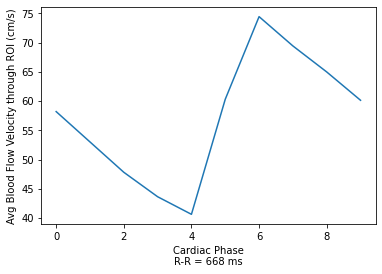

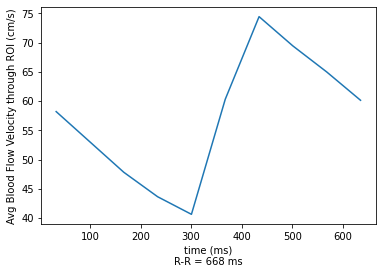

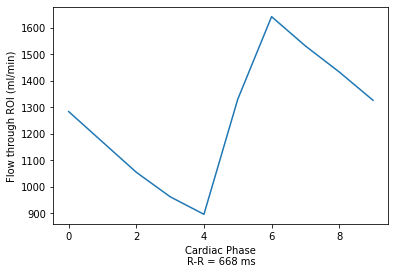

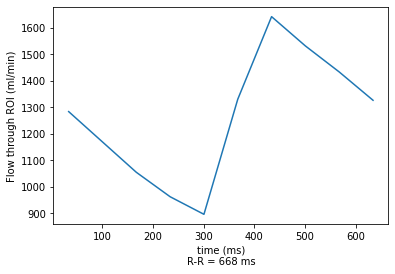

In [24]:
# make some plots
index = 0
print('Examining vessel: %s' % flows.vessel[index])
if np.mean(flows.avg_vel[index]) < 0:
    print('\n!!!!\nNEGATIVE VELOCITY, INVERTING\n!!!!\n')
    avg_vel = -flows.avg_vel[index]
    flow = -flows.flow[index]
else:
    avg_vel = flows.avg_vel[index]
    flow = flows.flow[index]

# Avg Velocity versus cardiac phase
plt.plot(avg_vel)
plt.xlabel('Cardiac Phase\nR-R = %i ms' % RR)
plt.ylabel('Avg Blood Flow Velocity through ROI (cm/s)')

# Avg Velocity versus time
plt.figure()
# time axis

# Either enter or get RR
RR = 668

N_phases = 10
x_time = (np.r_[:N_phases]+0.5)*RR/N_phases
plt.plot(x_time,avg_vel)
plt.xlabel('time (ms)\nR-R = %i ms' % RR)
plt.ylabel('Avg Blood Flow Velocity through ROI (cm/s)')

# Flow through ROI versus cardiac phase
plt.figure()
plt.plot(flow * 60) #ml/min
plt.xlabel('Cardiac Phase\nR-R = %i ms' % RR)
plt.ylabel('Flow through ROI (ml/min)')

# Avg Velocity versus time
plt.figure()
plt.plot(x_time,flow*60) #ml/min
plt.xlabel('time (ms)\nR-R = %i ms' % RR)
plt.ylabel('Flow through ROI (ml/min)')

print('Mask area = %.2f cm^2' % flows.area[index])
print('Average velocity through the ROI across cardiac cycle is %.1f cm/s, peak velocity is %.1f cm/s' % (np.mean(avg_vel), np.max(avg_vel)) )
print('Average flow through the ROI across cardiac cycle is %.1f ml/min, peak flow is %.1f ml/min' % (np.mean(flow)*60, np.max(flow)*60) )